<a href="https://colab.research.google.com/github/scaairesearch/da_bias_demo/blob/main/demo_bias_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Find the list of image names - folder structure for a specific condition
2.   Find conditions - pickle the dataframe / list of images
3.   Create a generic data loader to give images for specific condition (works on based on list of image, image path provided) - use class DatasetEXPWIMAGECROPRACE(Dataset):
4.   Download model - all 3
5.   Run performance on the images based on dataloader
6.   Develop gradio app
7.   deploy gradio app
8.   look at GradCam



Demo - Bias

In [27]:
!pip install facenet-pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.0

In [49]:
# install general libraries
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from pathlib import Path
from torchvision import transforms

In [2]:
from facenet_pytorch import MTCNN

In [18]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

 Cuda Status : False
cpu


In [19]:
mtcnn = MTCNN(image_size=224, device= device)

### Loading CSV Files
These are result files based on validation results

In [3]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Google Drive is already mounted.


In [4]:
# base_dir = ""
non_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])
dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])
ewc_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])

In [5]:
# Rename the last column in each dataframe
non_dann_result.rename(columns={'p_emotion': 'p_emotion_non_dann'}, inplace=True)
dann_result.rename(columns={'p_emotion': 'p_emotion_dann'}, inplace=True)
ewc_dann_result.rename(columns={'p_emotion': 'p_emotion_ewc_dann'}, inplace=True)

In [6]:
non_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion_non_dann
167,167,afraid_African_214.jpg,Fear,African,Fear
2502,2502,afraid_american_238.jpg,Surprise,African,Fear
2069,2069,afraid_asian_103.jpg,Happy,Asian,Angry
1006,1006,afraid_asian_336.jpg,Surprise,Asian,Neutral
2424,2424,afraid_asian_367.jpg,Surprise,Asian,Neutral
...,...,...,...,...,...
4325,4325,unhappy_expression_537.jpg,Happy,White,Sad
2049,2049,unhappy_expression_643.jpg,Disgust,White,Disgust
8202,8202,unhappy_expression_730.jpg,Neutral,Asian,Disgust
8344,8344,unhappy_expression_749.jpg,Disgust,White,Happy


In [7]:
merged_df = non_dann_result.merge(dann_result, on=['image', 'gt_emotion', 'gt_race']).merge(ewc_dann_result, on=['image', 'gt_emotion', 'gt_race'])
merged_df.shape, merged_df.columns

((8458, 9),
 Index(['Unnamed: 0_x', 'image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
        'Unnamed: 0_y', 'p_emotion_dann', 'Unnamed: 0', 'p_emotion_ewc_dann'],
       dtype='object'))

In [8]:
merged_df.head()

,Unnamed: 0_x,image,gt_emotion,gt_race,p_emotion_non_dann,Unnamed: 0_y,p_emotion_dann,Unnamed: 0,p_emotion_ewc_dann
0,167,afraid_African_214.jpg,Fear,African,Fear,4064,Neutral,7694,Neutral
1,2502,afraid_american_238.jpg,Surprise,African,Fear,174,Neutral,293,Fear
2,2069,afraid_asian_103.jpg,Happy,Asian,Angry,4002,Angry,2763,Angry
3,1006,afraid_asian_336.jpg,Surprise,Asian,Neutral,845,Neutral,7041,Neutral
4,2424,afraid_asian_367.jpg,Surprise,Asian,Neutral,4416,Neutral,7260,Neutral


In [9]:
merged_df = merged_df[['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann', 'p_emotion_dann', 'p_emotion_ewc_dann']]

In [10]:
merged_df.shape, merged_df.columns,merged_df.head()

((8458, 6),
 Index(['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
        'p_emotion_dann', 'p_emotion_ewc_dann'],
       dtype='object'),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 0   afraid_African_214.jpg       Fear  African               Fear   
 1  afraid_american_238.jpg   Surprise  African               Fear   
 2     afraid_asian_103.jpg      Happy    Asian              Angry   
 3     afraid_asian_336.jpg   Surprise    Asian            Neutral   
 4     afraid_asian_367.jpg   Surprise    Asian            Neutral   
 
   p_emotion_dann p_emotion_ewc_dann  
 0        Neutral            Neutral  
 1        Neutral               Fear  
 2          Angry              Angry  
 3        Neutral            Neutral  
 4        Neutral            Neutral  )

## Conditions
1. Images that are ok in non_dann, dann, dann_ewc
2. Images that are nok in non_dann, ok in dann and dann_ewc
3. Images that are nok in non_dann, nok in dann and ok in dann_ewc
4. Images that are nok in non_dann, dann_ewc but ok in dann
5. Images which are non_ok on all 3

### Condition 1: Images that are predicted same in non_dann, dann, dann_ewc, ground truth

In [11]:
condition_1 = (merged_df['gt_emotion'] == merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])

In [12]:
filtered_df_condition_1 = merged_df[condition_1]
filtered_df_condition_1.shape, filtered_df_condition_1.head()

((1805, 6),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 5      afraid_asian_39.jpg    Neutral    Asian            Neutral   
 32  amazed_African_145.jpg      Happy  African              Happy   
 38  amazed_African_253.jpg      Happy  African              Happy   
 40   amazed_African_28.jpg      Happy  African              Happy   
 41  amazed_African_293.jpg    Neutral  African            Neutral   
 
    p_emotion_dann p_emotion_ewc_dann  
 5         Neutral            Neutral  
 32          Happy              Happy  
 38          Happy              Happy  
 40          Happy              Happy  
 41        Neutral            Neutral  )

In [ ]:
# df_merged_per_race = merged_df.groupby('gt_race').size().reset_index(name='merged_count')

In [ ]:
# filtered_df_condition_1_per_race= filtered_df_condition_1.groupby('gt_race').size().reset_index(name='condition_1_count')

In [13]:
def race_proportion(base_df, condition_df, column_name = 'gt_race'):#, column_name):
  base_df_col = f'{column_name}'+'_base'
  condition_df_col = f'{column_name}'+'_condition'
  base_df_per_column_name = base_df.groupby(column_name).size().reset_index(name=base_df_col)
  condition_df_per_column_name = condition_df.groupby(column_name).size().reset_index(name=condition_df_col)
  merged_df = base_df_per_column_name.merge(condition_df_per_column_name, on=column_name)


  merged_df[condition_df_col] =   merged_df[condition_df_col].fillna(0)
  # # merged_df[merged_df.columns[-1]] =   merged_df[merged_df.columns[-1]].fillna(0)
  proportion_col = f'{column_name}'+'_proportion'
  merged_df[proportion_col] = round(merged_df[condition_df_col] *100/ merged_df[base_df_col],2)
  print(merged_df.head())

  return merged_df
  # merged_df[] = merged_df[column_name].fillna(0)
  # print(merged_df.head())

In [14]:
race_proportion(merged_df, filtered_df_condition_1)

          gt_race  gt_race_base  gt_race_condition  gt_race_proportion
0         African           814                164               20.15
1           Asian          1072                212               19.78
2          Indian           580                102               17.59
3          Latino           194                 70               36.08
4  Middle Eastern           202                 33               16.34


,gt_race,gt_race_base,gt_race_condition,gt_race_proportion
0,African,814,164,20.15
1,Asian,1072,212,19.78
2,Indian,580,102,17.59
3,Latino,194,70,36.08
4,Middle Eastern,202,33,16.34
5,White,5596,1224,21.87


In [32]:
# race_proportion(df_merged_per_race,filtered_df_condition_1_per_race)

### Condition 2: Images that are nok in non_dann, ok in dann and dann_ewc

In [ ]:
condition_2 = (merged_df['gt_emotion'] != merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])

In [ ]:
filtered_df_condition_2 = merged_df[condition_2]
filtered_df_condition_2.shape, filtered_df_condition_2.head()

((278, 6),
                       image gt_emotion  gt_race p_emotion_non_dann  \
 18        afraid_man_41.jpg    Neutral  African            Disgust   
 31   amazed_African_141.jpg    Neutral  African            Disgust   
 242    amazed_black_160.jpg    Neutral  African                Sad   
 247    amazed_black_243.jpg    Neutral   Latino              Angry   
 267     amazed_boss_204.jpg      Angry    Asian              Happy   
 
     p_emotion_dann p_emotion_ewc_dann  
 18         Neutral            Neutral  
 31         Neutral            Neutral  
 242        Neutral            Neutral  
 247        Neutral            Neutral  
 267          Angry              Angry  )

## Generic Dataset and Dataloader creator

In [16]:

GDRIVE_FOLDER = '/content/gdrive/MyDrive/CV_FER'
RACEDS_PATH = Path(GDRIVE_FOLDER,'dataset','RaceTest_EXPW','EXPW_annotated')

/content/gdrive/MyDrive/CV_FER/dataset/RaceTest_EXPW/EXPW_annotated/Angry/Indian/mad_woman_95.jpg


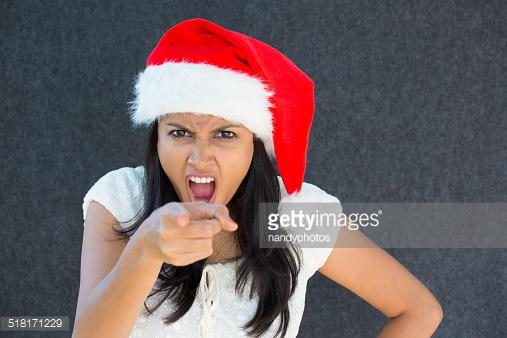

In [21]:
emotion = 'Angry'
race = 'Indian'
image_file_name = 'mad_woman_95.jpg'
image_full_path = Path(RACEDS_PATH,emotion,race,image_file_name)
print(image_full_path)
img = Image.open(image_full_path).convert("RGB")
img

In [22]:
# self.mtcnn = MTCNN(image_size=224, device= self.device)
img_cropped = mtcnn(img)
img_cropped

tensor([[[ 0.7852,  0.7852,  0.7930,  ...,  0.8867,  0.8867,  0.8867],
         [ 0.7852,  0.7852,  0.7930,  ...,  0.8867,  0.8867,  0.8867],
         [ 0.7930,  0.7930,  0.8008,  ...,  0.8867,  0.8867,  0.8867],
         ...,
         [ 0.4023,  0.4023,  0.4180,  ..., -0.8320, -0.8398, -0.8398],
         [ 0.4258,  0.4258,  0.4414,  ..., -0.8242, -0.8398, -0.8398],
         [ 0.4336,  0.4336,  0.4492,  ..., -0.8242, -0.8398, -0.8398]],

        [[ 0.8555,  0.8555,  0.8477,  ...,  0.8945,  0.8945,  0.8945],
         [ 0.8555,  0.8555,  0.8477,  ...,  0.8945,  0.8945,  0.8945],
         [ 0.8633,  0.8633,  0.8555,  ...,  0.8945,  0.8945,  0.8945],
         ...,
         [ 0.5117,  0.5117,  0.5195,  ..., -0.8789, -0.8711, -0.8711],
         [ 0.5195,  0.5195,  0.5273,  ..., -0.8711, -0.8711, -0.8711],
         [ 0.5273,  0.5273,  0.5352,  ..., -0.8633, -0.8711, -0.8711]],

        [[ 0.9102,  0.9102,  0.9102,  ...,  0.9102,  0.9102,  0.9102],
         [ 0.9102,  0.9102,  0.9102,  ...,  0

In [24]:
print(torch.min(img_cropped), torch.max(img_cropped))
image_cropped_rescaled = (img_cropped + 1) / 2
print(torch.min(image_cropped_rescaled), torch.max(image_cropped_rescaled))

tensor(-0.9961) tensor(0.9961)
tensor(0.0020) tensor(0.9980)


In [28]:
image_cropped_rescaled.shape

torch.Size([3, 224, 224])

In [81]:
def show_image(image_tensor):
  image_tensor_np = image_tensor.numpy()

  # Since Matplotlib expects images in (H, W, C) format, transpose the tensor from (C, H, W)
  image_tensor_np = np.transpose(image_tensor_np, (1, 2, 0))

  # Display the image using Matplotlib
  plt.imshow(image_tensor_np)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  img

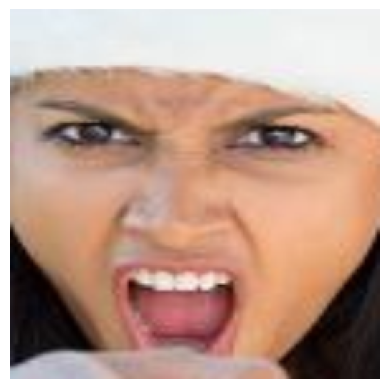

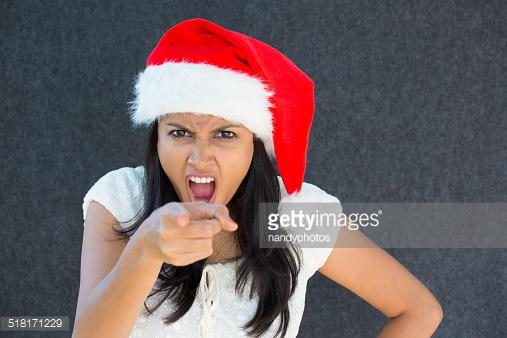

In [82]:
# Convert the tensor to a numpy array
image_cropped_np = image_cropped_rescaled.numpy()

# Since Matplotlib expects images in (H, W, C) format, transpose the tensor from (C, H, W)
image_cropped_np = np.transpose(image_cropped_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_cropped_np)
plt.axis('off')  # Turn off axis labels
plt.show()
img

In [83]:
import torch

# Define the labels map
labels_map = {
    "0": "angry",
    "1": "disgust",
    "2": "fear",
    "3": "happy",
    "4": "sad",
    "5": "surprise",
    "6": "neutral"
}

# List of labels
labels = list(labels_map.values())

# Create the one-hot encoding matrix
label_matrix = torch.eye(len(labels))

# Function to get the one-hot vector for a specific emotion
def get_one_hot_vector(emotion, labels = labels, label_matrix= label_matrix):
    if emotion in labels:
        idx = labels.index(emotion)
        return label_matrix[idx]
    else:
        raise ValueError(f"Emotion '{emotion}' not found in labels.")

In [47]:
# for _,emotion in labels_map.items():
#   print(get_one_hot_vector(emotion))

In [48]:
# label_matrix[1,:]== label_matrix[1]
# print(label_matrix[1,:],label_matrix[1])

In [84]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, dataframe,
                 transform=None,
                 datafolder_path = RACEDS_PATH,
                 image_file_colname = 'image',
                 race_colname  = 'gt_race',
                 gt_emotion_colname  = 'gt_emotion'):
        self.dataframe = dataframe
        self.transform = transform
        self.image_file_colname = image_file_colname
        self.race_colname = race_colname
        self.gt_emotion_colname = gt_emotion_colname

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # TODO: provide original image, provide cropped image, ground truth label, race

        # img_filename = self.dataframe.loc[idx, self.image_file_colname]
        # race = self.dataframe.loc[idx, self.race_colname]
        # emotion = self.dataframe.loc[idx, self.gt_emotion_colname]
        img_filename = self.dataframe.iloc[idx, 0]
        race = self.dataframe.iloc[idx, 2]
        emotion = self.dataframe.iloc[idx, 1]
        emotion_one_hot = get_one_hot_vector(emotion.lower())
        image_full_path = Path(RACEDS_PATH,emotion,race,img_filename)

        image = Image.open(image_full_path).convert("RGB")
        cropped_image = mtcnn(image)
        print(type(cropped_image))
        # if cropped_image: #error in cropping
        #   cropped_image = (cropped_image + 1) / 2 # changing form -1,1 to 0,1
        # else:
        #   cropped_image = image

        # if self.transform:
        #     image = self.transform(cropped_image)

        return cropped_image, emotion#, image, race


In [69]:
filtered_df_condition_1 =filtered_df_condition_1.iloc[:1]
filtered_df_condition_1

,image,gt_emotion,gt_race,p_emotion_non_dann,p_emotion_dann,p_emotion_ewc_dann
5,afraid_asian_39.jpg,Neutral,Asian,Neutral,Neutral,Neutral


In [90]:
# Define  transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Create an instance of your custom dataset
dataset = CustomImageDataset(dataframe=filtered_df_condition_1, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Example of iterating through the DataLoader
# for cropped_image, emotion, image, race in dataloader:
for cropped_image, emotion in dataloader:

    print(cropped_image.squeeze().shape)
    show_image(cropped_image)
    # show_image (image)
    print(emotion)
    # print(race)


<class 'torch.Tensor'>
torch.Size([3, 224, 224])


ValueError: axes don't match array

In [67]:
next(iter(dataloader))

KeyError: 0